In [1]:
import numpy as np
import struct

# -------------------------
# Function to load MNIST ubyte
# -------------------------
def load_mnist_images(filename, max_samples=None):
    with open(filename, 'rb') as f:
        # Read header
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        # Read data
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num, rows, cols)
        # Normalize to [0,1]
        images = images.astype(np.float32) / 255.0
        if max_samples:
            images = images[:max_samples]
        return images

def load_mnist_labels(filename, max_samples=None):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        if max_samples:
            labels = labels[:max_samples]
        return labels

In [2]:
# -------------------------
# Load small subset
# -------------------------
train_images = load_mnist_images('../input/mnist-dataset/train-images.idx3-ubyte', max_samples=5000)
train_labels = load_mnist_labels('../input/mnist-dataset/train-labels.idx1-ubyte', max_samples=5000)

test_images = load_mnist_images('../input/mnist-dataset/t10k-images.idx3-ubyte', max_samples=1000)
test_labels = load_mnist_labels('../input/mnist-dataset/t10k-labels.idx1-ubyte', max_samples=1000)

print("Train images:", train_images.shape)
print("Train labels:", train_labels.shape)
print("Test images:", test_images.shape)
print("Test labels:", test_labels.shape)

Train images: (5000, 28, 28)
Train labels: (5000,)
Test images: (1000, 28, 28)
Test labels: (1000,)


=== Train Dataset ===
Number of samples: 5000
Image shape: (28, 28)
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Class 0: 479 samples
Class 1: 563 samples
Class 2: 488 samples
Class 3: 493 samples
Class 4: 535 samples
Class 5: 434 samples
Class 6: 501 samples
Class 7: 550 samples
Class 8: 462 samples
Class 9: 495 samples


/tmp/ipykernel_55/1172102406.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(class_counts)), y=class_counts, palette="viridis")


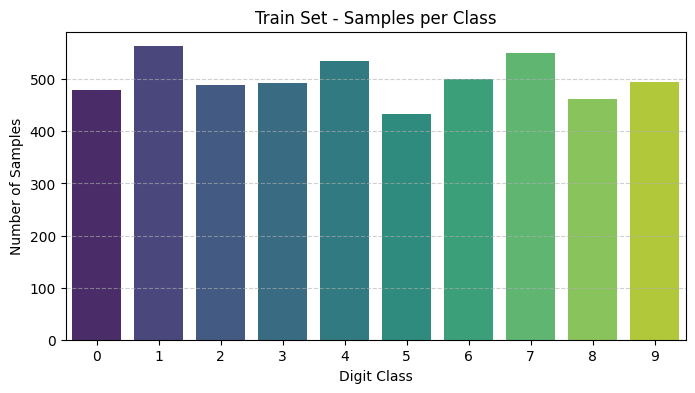

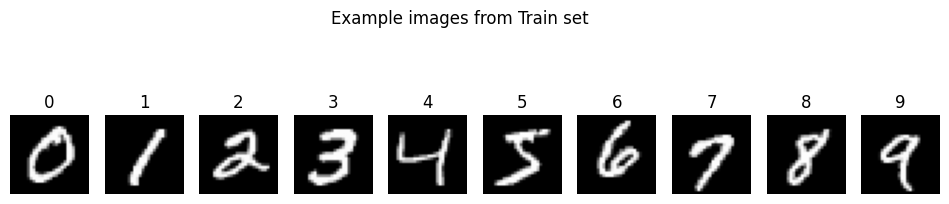

=== Test Dataset ===
Number of samples: 1000
Image shape: (28, 28)
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Class 0: 85 samples
Class 1: 126 samples
Class 2: 116 samples
Class 3: 107 samples
Class 4: 110 samples
Class 5: 87 samples
Class 6: 87 samples
Class 7: 99 samples
Class 8: 89 samples
Class 9: 94 samples


/tmp/ipykernel_55/1172102406.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(class_counts)), y=class_counts, palette="viridis")


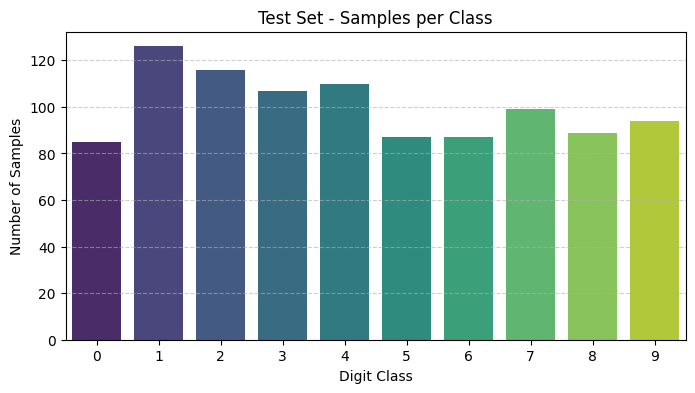

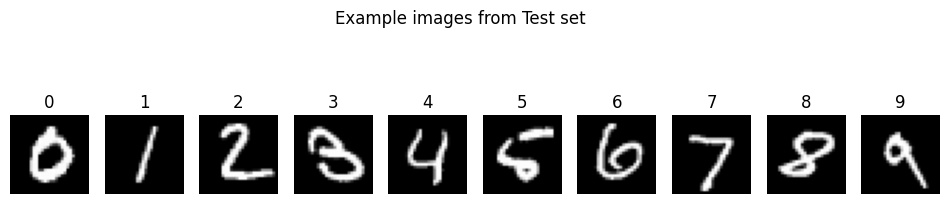

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

def dataset_statistics(images, labels, dataset_name="Train"):
    print(f"=== {dataset_name} Dataset ===")
    print("Number of samples:", len(labels))
    print("Image shape:", images.shape[1:])  # skip batch dimension
    print("Unique labels:", np.unique(labels))
    
    # Count samples per class
    class_counts = np.bincount(labels)
    for i, count in enumerate(class_counts):
        print(f"Class {i}: {count} samples")
    
    # Plot class distribution
    plt.figure(figsize=(8,4))
    sns.barplot(x=np.arange(len(class_counts)), y=class_counts, palette="viridis")
    plt.title(f"{dataset_name} Set - Samples per Class")
    plt.xlabel("Digit Class")
    plt.ylabel("Number of Samples")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
    
    # Optional: show some example images from each class
    plt.figure(figsize=(12,3))
    for i in range(10):
        idx = np.where(labels == i)[0][0]  # first sample of class i
        plt.subplot(1, 10, i+1)
        plt.imshow(images[idx], cmap='gray')
        plt.axis('off')
        plt.title(f"{i}")
    plt.suptitle(f"Example images from {dataset_name} set")
    plt.show()

# -------------------------
# Run diagnostics
# -------------------------
dataset_statistics(train_images, train_labels, "Train")
dataset_statistics(test_images, test_labels, "Test")

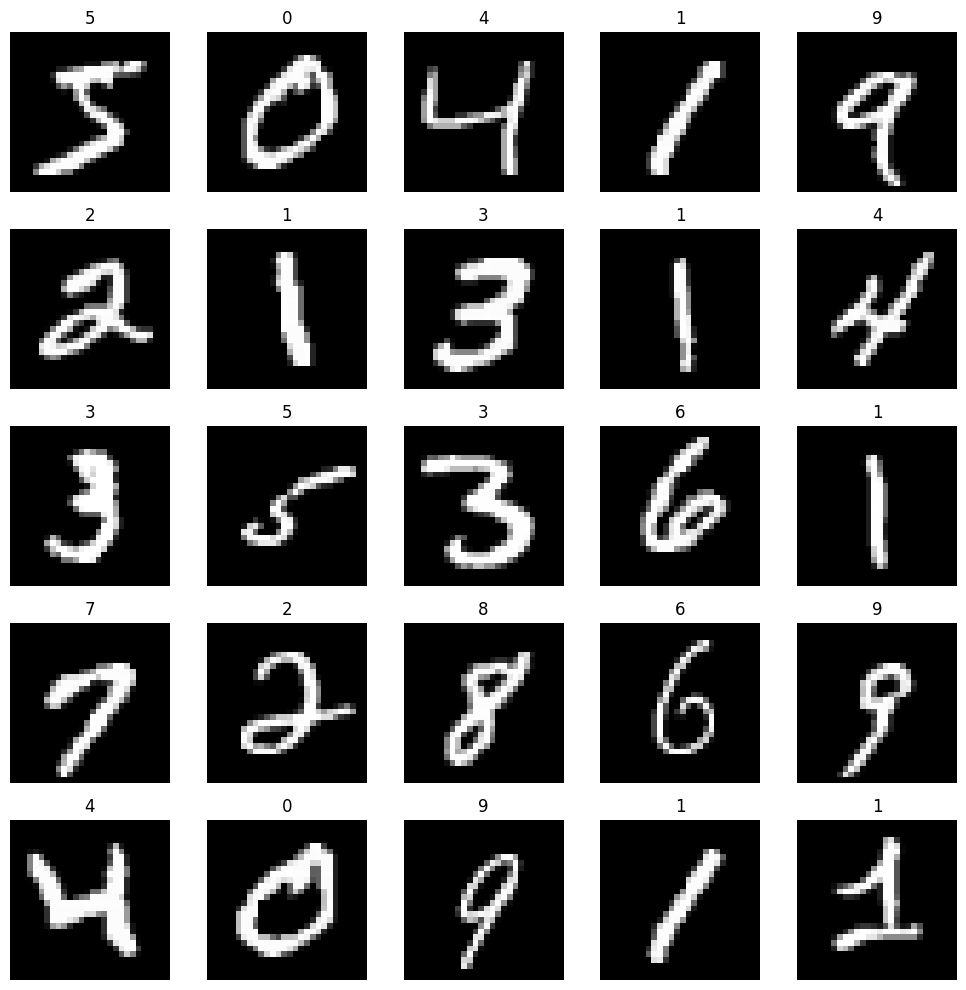

In [4]:
import matplotlib.pyplot as plt

# -------------------------
# Function to plot 5x5 grid
# -------------------------
def plot_mnist_grid(images, labels, grid_size=5):
    """
    Plots a grid of MNIST images with labels.

    images: numpy array of shape (N, 28, 28)
    labels: numpy array of shape (N,)
    grid_size: number of rows and cols (default 5x5)
    """
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten()
    
    for i in range(grid_size * grid_size):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(str(labels[i]))
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# -------------------------
# Example usage with your data
# -------------------------
plot_mnist_grid(train_images, train_labels)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    cohen_kappa_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
# -------------------------
# Flatten MNIST images for scikit-learn
# -------------------------
X_train = train_images.reshape(train_images.shape[0], -1)
X_test = test_images.reshape(test_images.shape[0], -1)
y_train = train_labels
y_test = test_labels
# -------------------------
# Define classifiers
# -------------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=200, solver='lbfgs', multi_class='auto'),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "DecisionTree": DecisionTreeClassifier(max_depth=10),
    "GaussianNB": GaussianNB(),
    "LinearSVC": LinearSVC(max_iter=2000),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=50, max_depth=10)
}

# -------------------------
# Metrics container
# -------------------------
metrics_names = ['accuracy', 'precision', 'recall', 'f1', 'cohen_kappa']
results = {name: [] for name in models.keys()}


In [6]:
# -------------------------
# Define classifiers
# -------------------------
models = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "DecisionTree": DecisionTreeClassifier(max_depth=10),
    "GaussianNB": GaussianNB(),
    "LinearSVC": LinearSVC(max_iter=2000),
}

# -------------------------
# Metrics container
# -------------------------
metrics_names = ['accuracy', 'precision', 'recall', 'f1', 'cohen_kappa']
results = {name: [] for name in models.keys()}
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# -------------------------
# Metrics container
# -------------------------

train_report = {}
test_report = {}

# -------------------------
# Cross-validation setup
# -------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------
# Scorers
# -------------------------
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

# -------------------------
# Train models and evaluate
# -------------------------
for name, model in models.items():
    print(f"Training {name}...")

    # Use cross_validate once for all metrics
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring=scorers,
        n_jobs=-1,  # parallelize folds if possible
        return_train_score=False
    )

    # Mapping metrics_names to scorer keys
    metric_key_map = {
        'accuracy': 'accuracy',
        'precision': 'precision_macro',
        'recall': 'recall_macro',
        'f1': 'f1_macro'
    }
    
    # Store CV metrics in train report (means/stds)
    train_report[name] = {
        **{metric + '_mean': np.mean(cv_results['test_' + metric_key_map[metric]])
           for metric in ['accuracy', 'precision', 'recall', 'f1']},
        **{metric + '_std': np.std(cv_results['test_' + metric_key_map[metric]])
           for metric in ['accuracy', 'precision', 'recall', 'f1']}
    }

    # Fit on full training set for test evaluation
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    # Compute metrics for test set
    test_report[name] = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test, average='macro'),
        'recall': recall_score(y_test, y_pred_test, average='macro'),
        'f1': f1_score(y_test, y_pred_test, average='macro')
    }

# -------------------------
# Display reports
# -------------------------
train_df = pd.DataFrame(train_report).T.round(4)
test_df = pd.DataFrame(test_report).T.round(4)

print("=== TRAINING REPORT (CV metrics) ===")
display(train_df)

print("\n=== TEST REPORT (full set metrics) ===")
display(test_df)

Training KNN...
Training DecisionTree...
Training GaussianNB...
Training LinearSVC...
=== TRAINING REPORT (CV metrics) ===


,accuracy_mean,precision_mean,recall_mean,f1_mean,accuracy_std,precision_std,recall_std,f1_std
KNN,0.9380,0.9409,0.9363,0.9373,0.0086,0.0074,0.0087,0.0083
DecisionTree,0.7780,0.7762,0.7745,0.7737,0.0112,0.0121,0.0108,0.0112
GaussianNB,0.6006,0.6621,0.5961,0.5667,0.0192,0.0206,0.0179,0.0240
LinearSVC,0.8814,0.8800,0.8787,0.8785,0.0076,0.0085,0.0076,0.0080



=== TEST REPORT (full set metrics) ===


,accuracy,precision,recall,f1
KNN,0.909,0.9106,0.9083,0.9078
DecisionTree,0.764,0.7589,0.7591,0.7578
GaussianNB,0.560,0.6498,0.5666,0.5228
LinearSVC,0.849,0.8481,0.8465,0.8464


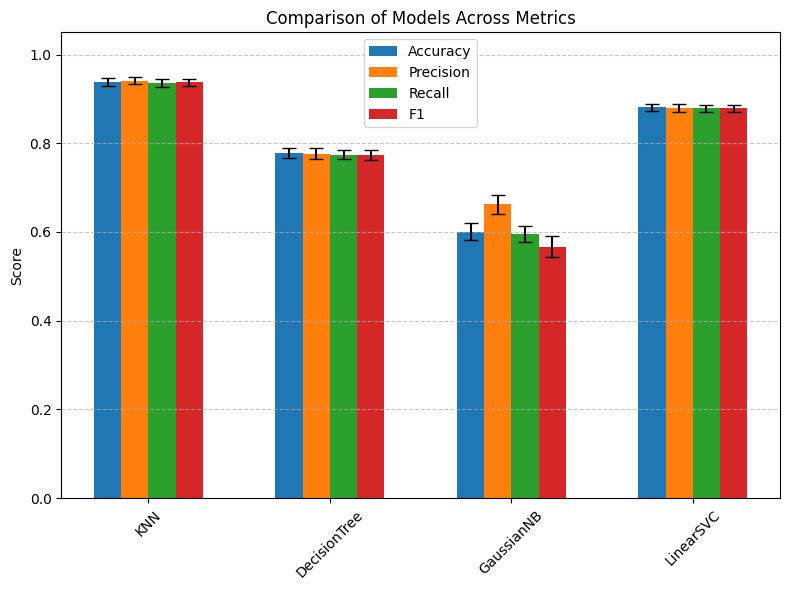

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Metrics to plot
# -------------------------
metrics_mean = ['accuracy_mean', 'precision_mean', 'recall_mean', 'f1_mean']
metrics_std  = ['accuracy_std', 'precision_std', 'recall_std', 'f1_std']
metric_labels = [m.replace("_mean","").replace("_"," ").title() for m in metrics_mean]

models_list = list(train_report.keys())
n_models = len(models_list)
n_metrics = len(metrics_mean)

# Bar width and positions
bar_width = 0.15
x = np.arange(n_models)

plt.figure(figsize=(n_models*2,6))  # make it wide if many models

# Plot each metric
for i, (mean_metric, std_metric) in enumerate(zip(metrics_mean, metrics_std)):
    means = [train_report[m][mean_metric] for m in models_list]
    stds  = [train_report[m][std_metric] for m in models_list]
    plt.bar(x + i*bar_width, means, width=bar_width, yerr=stds, capsize=5, label=metric_labels[i])

plt.xticks(x + bar_width*(n_metrics-1)/2, models_list, rotation=45)
plt.ylabel("Score")
plt.title("Comparison of Models Across Metrics")
plt.ylim(0,1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()